In [11]:
%%html
<center>Photo Credit: <a href="https://pixabay.com/illustrations/police-crime-scene-blue-light-2167968/">pixabay</a><BR><img src="img/police-2167968_1280.jpg" align="center"></center>

<h1><strong><center>CMSC320 Final Project<BR>Predicting the Crime 'Theft From Auto' in Washington, DC<center></strong></h1>
    <center><i>Group members: Leo Wu, Kevin Nguyen, Cindy Huynh<BR>Spring 2020 - Hector Corada Bravo</i></center>

# Introduction

Crime culture is different in different areas. 
In the past, Chicago and Los Angeles have been known for gangs (ChicagoMag, 2012).
Currently, Baltimore, Maryland, is considered the deadliest US city with 348 killings by the end of 2019, which is not the final value yet (Kennedy, 2020).
Therefore, due to the proximity of Washington, DC to the University of Maryland, we wanted to examine crime in Washington, DC.
According to the Patch, DC was ranked America's 16th most dangerous city in 2017 (2018).

At DC Atlas, we noticed that Theft From Auto appeared to be significant, in regards to Property Crime (2020). 
According to City of Cincinnati, Ohio, "Theft from Auto" is a crime of opportunity and is preventable (2020).

The question we are interested in is, what are the trends of crime in DC, and would we be able to predict 'Theft from Auto' crime in DC with data for ten years of data 2010-2019?

References:
How to Prevent Theft From Autos. (2020, May 17). City of Cincinnati. https://www.cincinnati-oh.gov/police/community-involvement/how-to-prevent-theft-from-autos/ 
Moser, W. (2012, Jan 27). Why Are There So Many Gang Members in Chicago? Chicago Magazine. https://www.chicagomag.com/Chicago-Magazine/The-312/January-2012/Why-Are-There-So-Many-Gang-Members-in-Chicago/
Kennedy, S. (2020, Feb 7). 'The Wire' Is Finished, but Baltimore Still Bleeds. Wall Street Journal. https://www.wsj.com/articles/the-wire-is-finished-but-baltimore-still-bleeds-11581119104
DC Atlas. (2020). Crime Cards. Metropolitan Police Department. https://dcatlas.dcgis.dc.gov/crimecards/ 
Taylor, D. (2018, Feb 20). The Patch. https://patch.com/district-columbia/washingtondc/dc-americas-16th-most-dangerous-city 
    
Interesting Links:
Grawert A., and Kimble, C. (2019, Dec 18). Takeaways from 2019 Crime Data in Major American Cities https://www.brennancenter.org/our-work/analysis-opinion/takeaways-2019-crime-data-major-american-cities
Madhani, A. (2018, Feb 19). USA Today. Baltimore is the nation's most dangerous big city. https://www.usatoday.com/story/news/2018/02/19/homicides-toll-big-u-s-cities-2017/302763002/
Best Places. (2020). 2020 Compare Crime Rates: Washington, DC vs Baltimore, MD. https://www.bestplaces.net/crime/?city1=51150000&city2=52404000 
The Disaster Center. (2007). US States Crime 2004 -2005 Crimes per 100,000 and Ranking. http://www.disastercenter.com/crime/US_States_Rate_Ranking.html   


In [1]:
#Importing required libraries
from ipyleaflet import *
import warnings
import pandas as pd
import sklearn.ensemble
from sklearn import neighbors
from sklearn.model_selection import KFold
import sklearn.metrics
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'ipyleaflet'

# Data Curation
<span style="font-family: Arial">
The data was obtained from Open Data DC site at https://opendata.dc.gov/datasets/crime-incidents-in-2010 through https://opendata.dc.gov/datasets/crime-incidents-in-2019. 
Spreadsheets were downloaded from the site and combined into one spreadsheet for ten years of data from 2010 to 2019.
Approximately 33,000 to 38,000 entities/observations were obtained from each year, totalling approximately 350,000 observation in total (349,343 to be exact).<BR><BR>
We dropped any unnecessary columns of data, leaving only the latitude as X, longitude as Y, report date (date the police officer recorded the report), start date (the date the crime started), end date (date the crime supposedly ended), and offense (theft from auto).<BR><BR>
To tidy our data, we then dropped any entities/observations with missing data in any fields. We converted any date/time fields to datetime objects in python. Examples and usage can be found at <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html">https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html</a> and <a href="https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/pandas/pandas_datetime.ipynb">https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/pandas/pandas_datetime.ipynb</a>. 
We removed entities/observations that had dates prior to 2010. <BR><BR>
The report dates would report crime that did not necessarily start in 2010, so we dropped that data, as those were not a significant amount of entities. 
Of that data, we chose to filter out only the data pertaining to "THEFT F/AUTO" which is a sizeable amount of data from our dataset.<BR><BR>
Our entire dataset is saved in df dataframe, in order to make our predictions for the year 2020.<BR>

We then chose to sample 1000 observations from the dataset for df2.

In [25]:
#read the CSV file, filter for TFA offenses, drop unnecessary columns, then drop rows with fields that contain NA in any fields
df = (pd.read_csv("./Crime_Incidents_in_2010_to_2019.csv")
        .query('OFFENSE == "THEFT F/AUTO"')
        .drop(columns = ['BID','LONGITUDE','LATITUDE','VOTING_PRECINCT', 'OBJECTID',
                        'OCTO_RECORD_ID','CCN','SHIFT','BLOCK','XBLOCK','YBLOCK','WARD',
                        'ANC','DISTRICT','PSA','METHOD','NEIGHBORHOOD_CLUSTER','BLOCK_GROUP',
                        'CENSUS_TRACT'])
        .dropna())

#converting date/time text to datetime objects
df['START_DATE'] = pd.to_datetime(df.START_DATE, format="%Y-%m")
df['END_DATE'] = pd.to_datetime(df.END_DATE, format="%Y-%m")
df['REPORT_DAT'] = pd.to_datetime(df.REPORT_DAT, format="%Y-%m")
df #entire dataset for prediction task

#sample size of 1000 for mapping
df2 = df.sample(n=1000) 
#display the dataframe
df.head()

,X,Y,REPORT_DAT,START_DATE,END_DATE,OFFENSE
254958,-77.030325,38.907244,2017-01-12 13:33:22+00:00,2017-01-12 10:17:06+00:00,2017-01-12 11:46:56+00:00,THEFT F/AUTO
124584,-76.990520,38.857467,2013-10-23 06:18:00+00:00,2013-10-22 00:01:00+00:00,2013-10-22 07:25:00+00:00,THEFT F/AUTO
163306,-77.040820,38.913357,2014-11-23 15:00:00+00:00,2014-11-20 00:01:00+00:00,2014-11-21 08:15:00+00:00,THEFT F/AUTO
107693,-77.001317,38.914085,2013-04-14 06:59:00+00:00,2013-04-13 17:00:00+00:00,2013-04-14 06:55:00+00:00,THEFT F/AUTO
34849,-77.034537,38.964193,2011-02-13 15:20:00+00:00,2011-02-12 17:00:00+00:00,2011-02-13 13:00:00+00:00,THEFT F/AUTO


<strong>Map Title:</strong> Theft From Auto Crime from 2010-2019 in DC<BR>
<strong>Description:</strong> The data can be plotted on to a map, especially if it has geographical coordinates, longitude and latitude. This map shows each theft from automobile crime that was taken in the sample from the dataframe. This is the geographical map with data points for a sample size of 1000 from data containing observations for theft from auto crimes from 2010-2019. The the sample dataset was used to plot the points in the map below using the python map module. See <a href="https://docs.python.org/3/library/functions.html#map">https://docs.python.org/3/library/functions.html#map</a> for more information. 

In [55]:
m = Map(center = (38.8951, -77.0364), zoom = 11)
for i in df2.iterrows():
    data = i[1]
    circle = Circle()
    circle.location = (data[1], data[0])
    circle.radius = 1
    circle.color = "green"
    circle.fill_color = "green"
    
    m.add_layer(circle)
m

Map(center=[38.9072, -77.0369], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

## Prediction task - Machine Learning
> Can we predict the number of theft from automobiles in 2020?


In [56]:
#We create another dataframe that shows how much TFA occurred each year
tmp = pd.DataFrame(columns = ['# of Theft From Auto'], 
                   index = ['2010', '2011','2012','2013','2014',
                            '2015','2016','2017','2019'])
# any NA values will be marked as 0 instead
tmp = tmp.fillna(0)

#interate through all rows to see if the year matches
for i in df.iterrows():
    datetime = i[1][3].to_pydatetime() #uses matching start date
    for j in tmp.iterrows():
        if str(datetime.year) == j[0]:
            tmp['# of Theft From Auto'][j[0]] += 1
tmp

,# of Theft From Auto
2010,85
2011,103
2012,99
2013,118
2014,120
2015,128
2016,123
2017,102
2019,120


The data gathered from the 2018 csv file was incomplete, with only crimes recorded in June on it. With it, the data would've had a strange divot in its trend over time. Therefore, we chose to exclude it from our data.

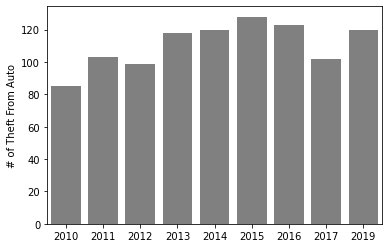

In [62]:
g = sns.barplot(x = tmp.index, y = tmp['# of Theft From Auto'], color = 'grey')
g

The barplot above indicates the frequency of theft from cars from the years 2010-2019.


In [121]:
df['YEAR'] = df['REPORT_DAT'].apply(lambda x: x.to_pydatetime().year)
df

,X,Y,REPORT_DAT,START_DATE,END_DATE,OFFENSE,YEAR
254958,-77.030325,38.907244,2017-01-12 13:33:22+00:00,2017-01-12 10:17:06+00:00,2017-01-12 11:46:56+00:00,THEFT F/AUTO,2017
124584,-76.990520,38.857467,2013-10-23 06:18:00+00:00,2013-10-22 00:01:00+00:00,2013-10-22 07:25:00+00:00,THEFT F/AUTO,2013
163306,-77.040820,38.913357,2014-11-23 15:00:00+00:00,2014-11-20 00:01:00+00:00,2014-11-21 08:15:00+00:00,THEFT F/AUTO,2014
107693,-77.001317,38.914085,2013-04-14 06:59:00+00:00,2013-04-13 17:00:00+00:00,2013-04-14 06:55:00+00:00,THEFT F/AUTO,2013
34849,-77.034537,38.964193,2011-02-13 15:20:00+00:00,2011-02-12 17:00:00+00:00,2011-02-13 13:00:00+00:00,THEFT F/AUTO,2011
...,...,...,...,...,...,...,...
294262,-76.999518,38.899564,2019-01-25 23:35:12+00:00,2019-01-25 22:00:02+00:00,2019-01-25 22:16:14+00:00,THEFT F/AUTO,2019
61606,-76.973985,38.863536,2011-11-27 02:16:00+00:00,2011-11-26 17:00:00+00:00,2011-11-27 15:25:00+00:00,THEFT F/AUTO,2011
224007,-76.980738,38.904201,2016-06-23 21:11:59+00:00,2016-06-22 08:00:02+00:00,2016-06-22 16:30:40+00:00,THEFT F/AUTO,2016
77373,-76.967102,38.872939,2012-06-12 14:00:00+00:00,2012-06-12 12:00:00+00:00,2012-06-12 14:00:00+00:00,THEFT F/AUTO,2012


In [146]:
X = df.iloc[:,1:2].to_numpy()
y = df.iloc[:,6:7].to_numpy()
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(X)
print(kf)  

KFold(n_splits=10, random_state=None, shuffle=True)


In [151]:
k = 1
k = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = neighbors.KNeighborsClassifier(k, weights='uniform')
    clf.fit(X_train, y_train)
    k = k + 1
    Z = clf.predict(X_test)
    y_test = np.ravel(y_test)
    print(sklearn.metrics.zero_one_loss(y_test,Z))

0.85
0.92
0.9
0.9
0.94
0.87
0.9
0.87
0.89
0.91


high error, cannot predict